In [1]:
from sklearn.metrics import silhouette_score
import pickle
import torch
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

In [2]:
def train(embeddings, labels, classes, epochs=30, test_split=0.2, normalize=False):
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import TensorDataset, DataLoader
    from sklearn.metrics import accuracy_score, f1_score
    from tqdm import tqdm
    import matplotlib.pyplot as plt

    # Use CUDA if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Shuffle data
    indices = torch.randperm(embeddings.size(0))
    shuffled_data = embeddings[indices].to(device)
    shuffled_labels = [labels[i] for i in indices.tolist()]
    
    # Map labels to indices
    unique_labels = sorted(set(shuffled_labels))
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    y = torch.tensor([label_to_idx[label] for label in shuffled_labels], dtype=torch.long).to(device)
    
    # Split data into training and test sets
    total_samples = shuffled_data.size(0)
    train_size = int((1 - test_split) * total_samples)
    
    train_data = shuffled_data[:train_size]
    train_labels = y[:train_size]
    test_data = shuffled_data[train_size:]
    test_labels = y[train_size:]
    
    # Prepare DataLoader for training data
    train_dataset = TensorDataset(train_data, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    
    # Define model and send to device
    # it was linear128 - relu - dropout - linear before
    layers = [
        nn.Linear(embeddings.size(1), classes),
    ]
    if normalize:
        layers.insert(0, nn.BatchNorm1d(embeddings.size(1)))
    model = nn.Sequential(*layers).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    epoch_losses = []
    model.train()
    for epoch in tqdm(range(epochs), desc="Training epochs"):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_loss)
    
    # Plot training loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), epoch_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.grid(True)
    plt.show()
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        outputs = model(train_data)
        _, preds = torch.max(outputs, 1)
    
    acc = accuracy_score(train_labels.cpu().numpy(), preds.cpu().numpy())
    f1 = f1_score(train_labels.cpu().numpy(), preds.cpu().numpy(), average='weighted')
    print(f"Train Accuracy: {acc:.4f}, Train F1 Score: {f1:.4f}")
    
    with torch.no_grad():
        outputs = model(test_data)
        _, preds = torch.max(outputs, 1)
    
    acc = accuracy_score(test_labels.cpu().numpy(), preds.cpu().numpy())
    f1 = f1_score(test_labels.cpu().numpy(), preds.cpu().numpy(), average='weighted')
    print(f"Test Accuracy: {acc:.4f}, Test F1 Score: {f1:.4f}")
    
    return f1



In [3]:
# from WhiteningBERT
def whitening_torch_final(embeddings):
    mu = torch.mean(embeddings, dim=0, keepdim=True)
    cov = torch.mm((embeddings - mu).t(), embeddings - mu)
    u, s, vt = torch.svd(cov.float())
    W = torch.mm(u, torch.diag(1/torch.sqrt(s)))
    embeddings = torch.mm(embeddings - mu, W)
    return embeddings

In [4]:
def decorr_only(embeddings):
    cov = embeddings.T @ embeddings / (embeddings.size(0) - 1)
    u, _, _ = torch.svd(cov.float())
    embeddings_decorrelated = embeddings @ u
    return embeddings_decorrelated

In [5]:
def f1_improvement(filepath, classes, mapping, epochs=30):
    with open(filepath, "rb") as f:
        embeddings, filenames = pickle.load(f)

    filenames = [mapping(x) for x in filenames]
    f1 = train(embeddings, filenames, classes, epochs)
    f1_d = train(decorr_only(embeddings), filenames, classes, epochs)
    f1_n = train(embeddings, filenames, classes, epochs, normalize=True)
    f1_w = train(whitening_torch_final(embeddings), filenames, classes, epochs)
    print(f"Decorrelation improvement: {f1_d - f1}")
    print(f"BatchNorm improvement: {f1_n - f1}")
    print(f"Whitening improvement: {f1_w - f1}")

## netmamba

In [6]:
def mapping(x):
    return x.removeprefix("/dev/shm/data/").split('/')[2]

Training epochs: 100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


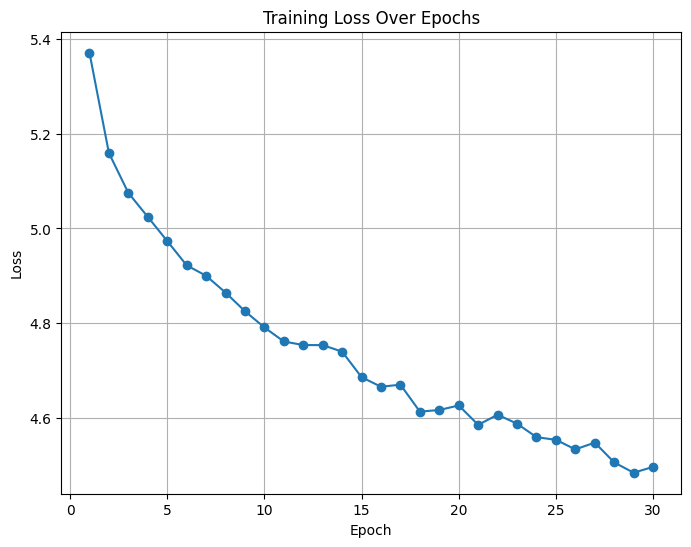

Train Accuracy: 0.1204, Train F1 Score: 0.1264
Test Accuracy: 0.1139, Test F1 Score: 0.1163


Training epochs: 100%|██████████| 30/30 [00:14<00:00,  2.01it/s]


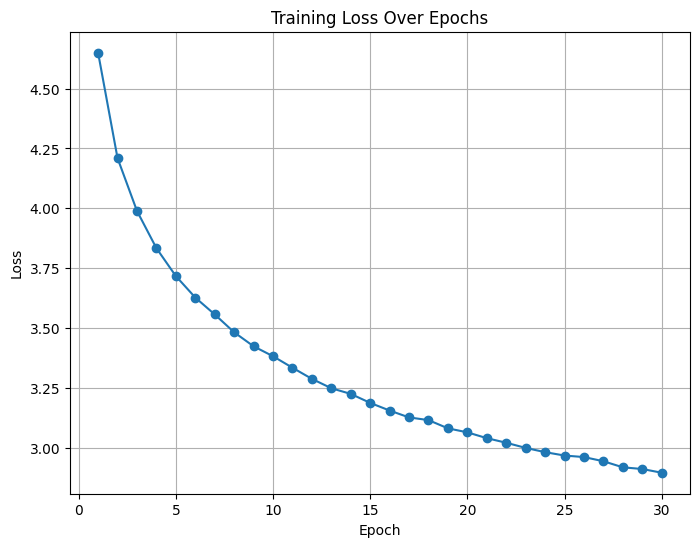

Train Accuracy: 0.4304, Train F1 Score: 0.4838
Test Accuracy: 0.3746, Test F1 Score: 0.4087


Training epochs: 100%|██████████| 30/30 [00:18<00:00,  1.62it/s]


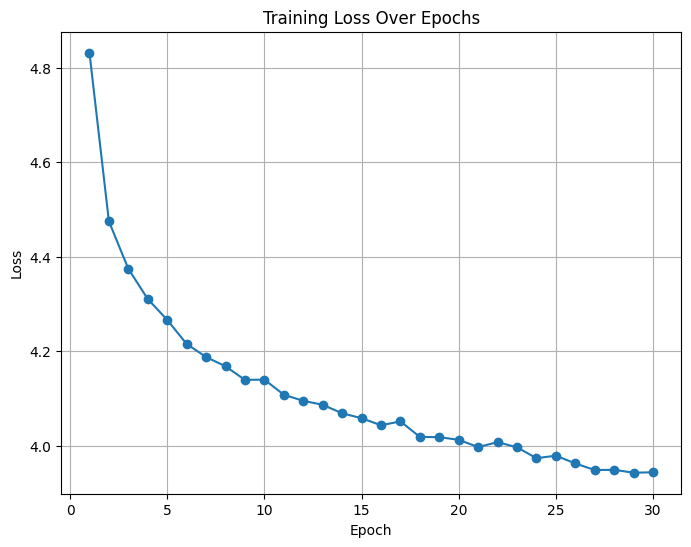

Train Accuracy: 0.2368, Train F1 Score: 0.2339
Test Accuracy: 0.2228, Test F1 Score: 0.2160


Training epochs: 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]


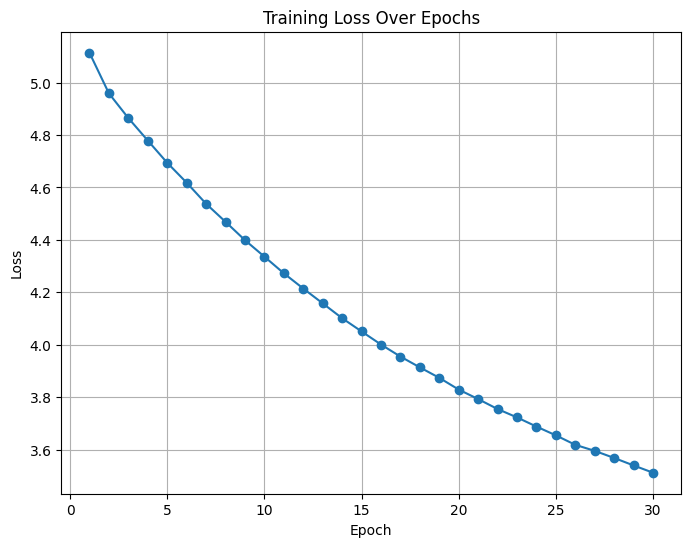

Train Accuracy: 0.3357, Train F1 Score: 0.3510
Test Accuracy: 0.2988, Test F1 Score: 0.3020
Decorrelation improvement: 0.29239379129472637
BatchNorm improvement: 0.09973386543663125
Whitening improvement: 0.1857100125433847


In [7]:
# netmamba - Crossmarket
f1_improvement("../data/netmamba/netmamba_cross_emb.pkl", 210, mapping)

Training epochs: 100%|██████████| 30/30 [02:57<00:00,  5.91s/it]


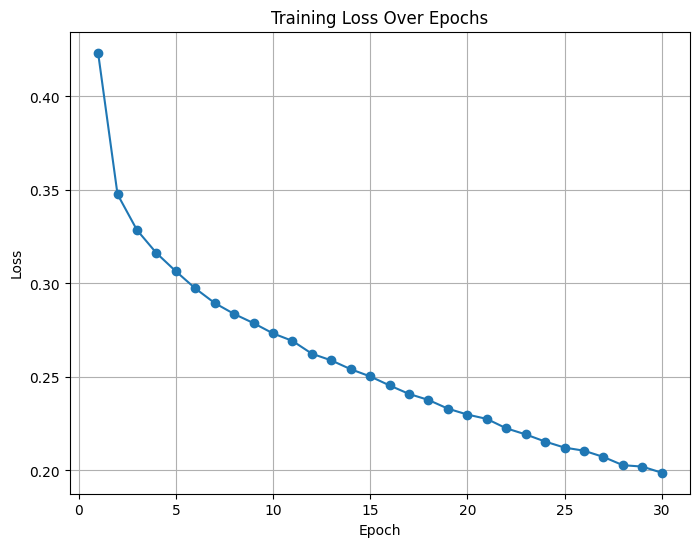

Train Accuracy: 0.8745, Train F1 Score: 0.8300
Test Accuracy: 0.8730, Test F1 Score: 0.8279


Training epochs: 100%|██████████| 30/30 [02:54<00:00,  5.80s/it]


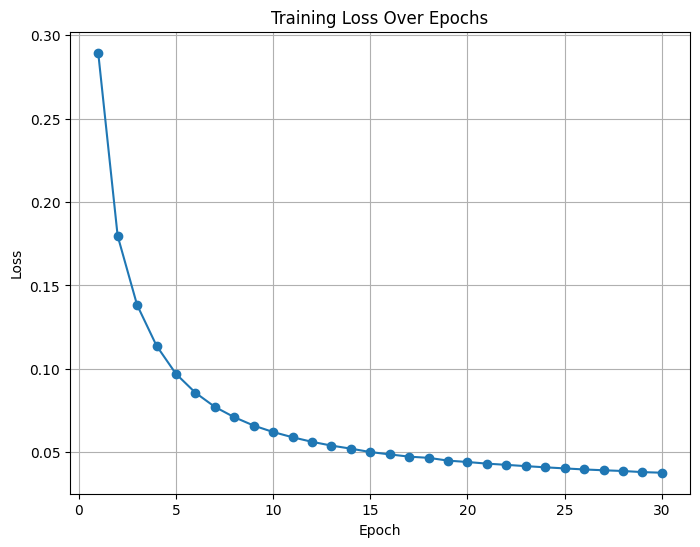

Train Accuracy: 0.9935, Train F1 Score: 0.9935
Test Accuracy: 0.9937, Test F1 Score: 0.9937


Training epochs:  33%|███▎      | 10/30 [01:14<02:28,  7.45s/it]


KeyboardInterrupt: 

In [8]:
# netmamba - cicids17
f1_improvement("../data/netmamba/netmamba_cicids_emb.pkl", 8, mapping)

Training epochs: 100%|██████████| 30/30 [05:36<00:00, 11.22s/it]


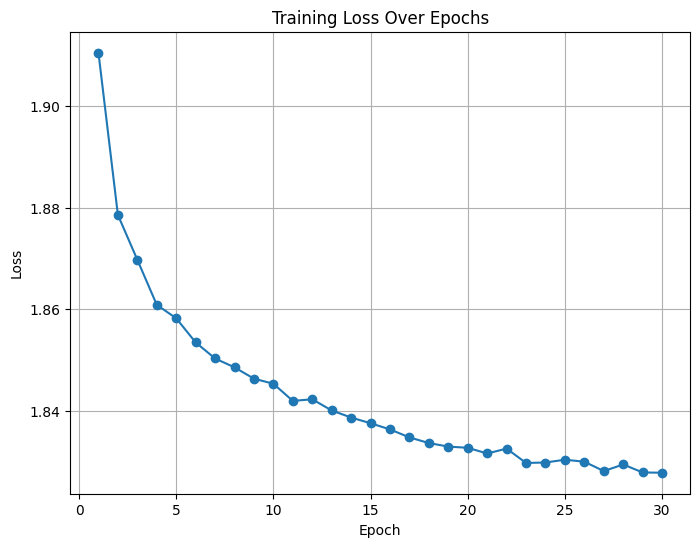

Train Accuracy: 0.2094, Train F1 Score: 0.0941
Test Accuracy: 0.2099, Test F1 Score: 0.0945


Training epochs: 100%|██████████| 30/30 [05:35<00:00, 11.18s/it]


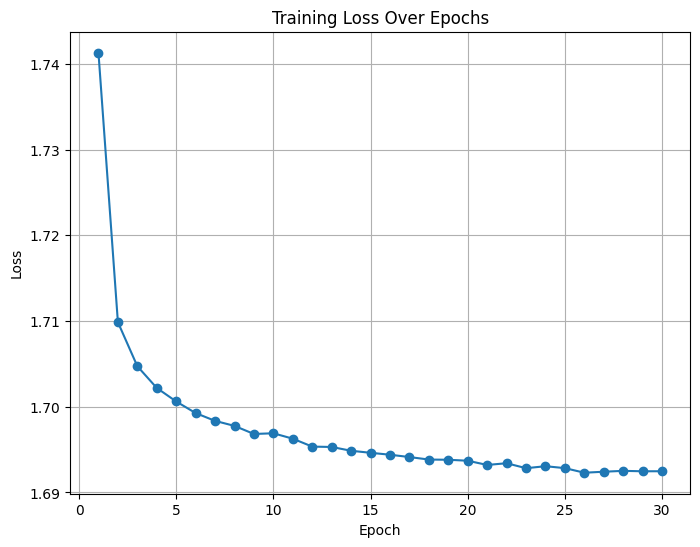

Train Accuracy: 0.2112, Train F1 Score: 0.1290
Test Accuracy: 0.2098, Test F1 Score: 0.1276


Training epochs: 100%|██████████| 30/30 [06:14<00:00, 12.48s/it]


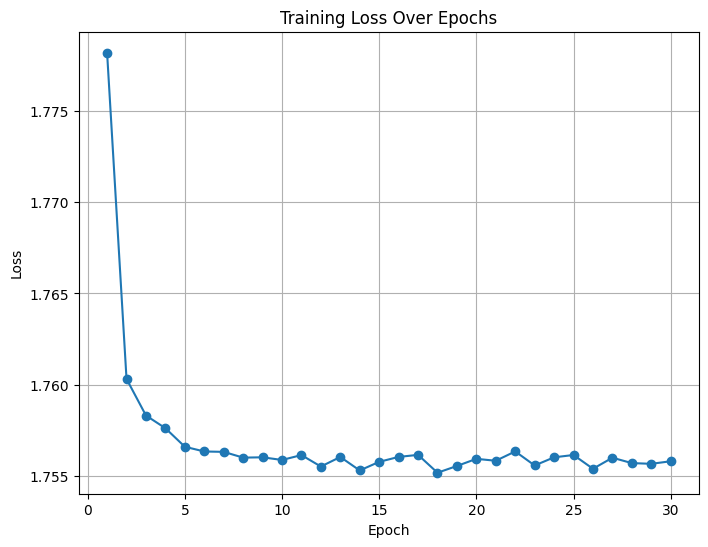

Train Accuracy: 0.2082, Train F1 Score: 0.1237
Test Accuracy: 0.2085, Test F1 Score: 0.1238


Training epochs: 100%|██████████| 30/30 [05:37<00:00, 11.23s/it]


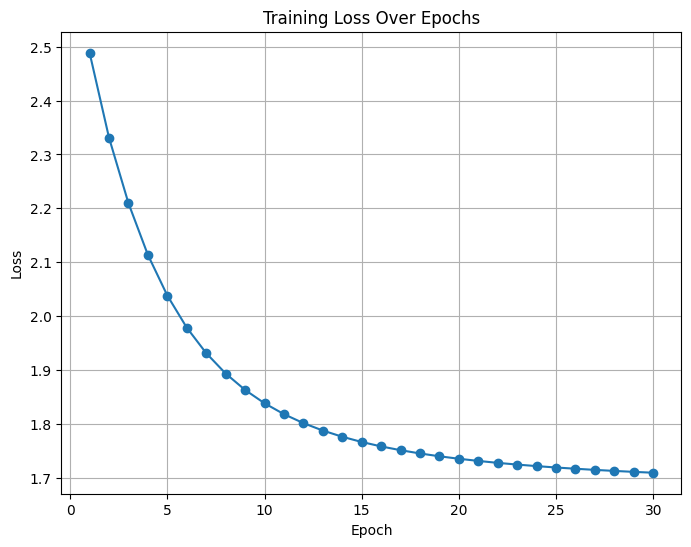

Train Accuracy: 0.2117, Train F1 Score: 0.1060
Test Accuracy: 0.2074, Test F1 Score: 0.1024
Decorrelation improvement: 0.03311128565983017
BatchNorm improvement: 0.02928431946859522
Whitening improvement: 0.007901067864281935


In [ ]:
# netmamba - cicapt
f1_improvement("../data/netmamba/netmamba_cicapt_emb.pkl", 22, mapping)

## yatc

In [ ]:
def mapping(x):
    return x.removeprefix("/dev/shm/data/").split('/')[2]

Training epochs: 100%|██████████| 30/30 [00:09<00:00,  3.24it/s]


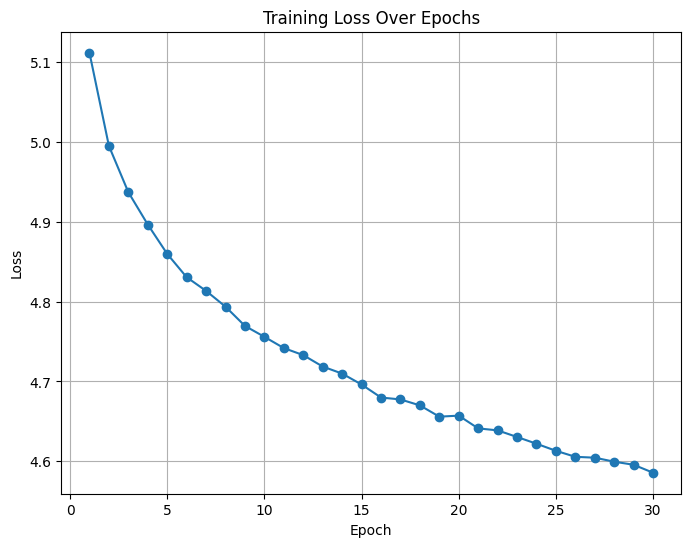

Train Accuracy: 0.0773, Train F1 Score: 0.0535
Test Accuracy: 0.0589, Test F1 Score: 0.0358


Training epochs: 100%|██████████| 30/30 [00:09<00:00,  3.21it/s]


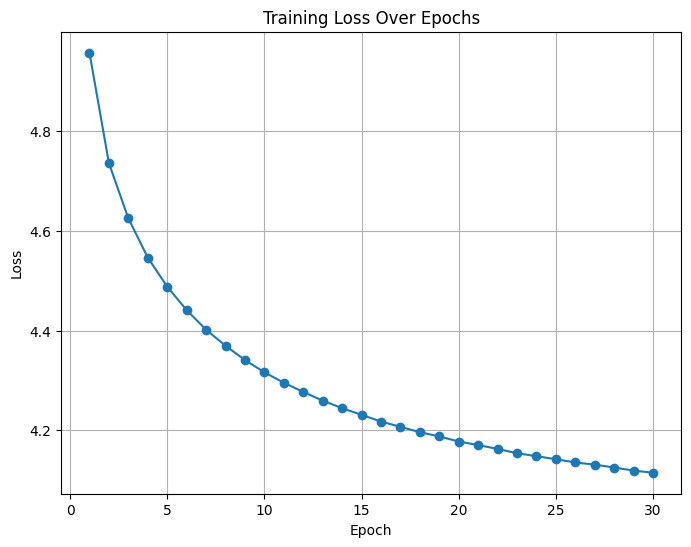

Train Accuracy: 0.1392, Train F1 Score: 0.1278
Test Accuracy: 0.0736, Test F1 Score: 0.0605


Training epochs: 100%|██████████| 30/30 [00:10<00:00,  2.91it/s]


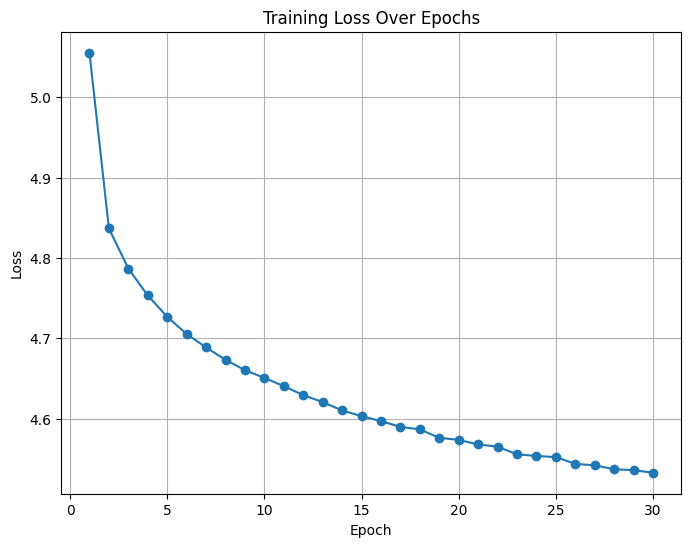

Train Accuracy: 0.0889, Train F1 Score: 0.0747
Test Accuracy: 0.0622, Test F1 Score: 0.0491


Training epochs: 100%|██████████| 30/30 [00:09<00:00,  3.20it/s]


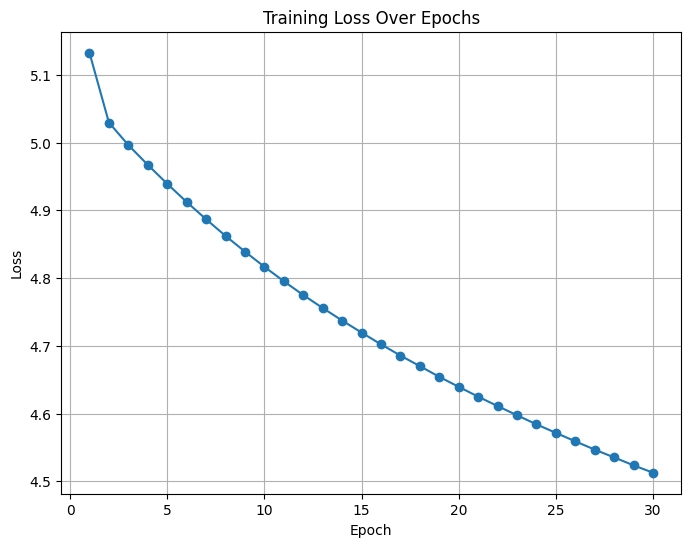

Train Accuracy: 0.0981, Train F1 Score: 0.0673
Test Accuracy: 0.0713, Test F1 Score: 0.0416
Decorrelation improvement: 0.02469790542409655
BatchNorm improvement: 0.01331090679715951
Whitening improvement: 0.005816196762058794


In [ ]:
# yatc - Crossmarket
f1_improvement("../data/yatc/cross_emb.pkl", 210, mapping)

Training epochs: 100%|██████████| 30/30 [01:58<00:00,  3.94s/it]


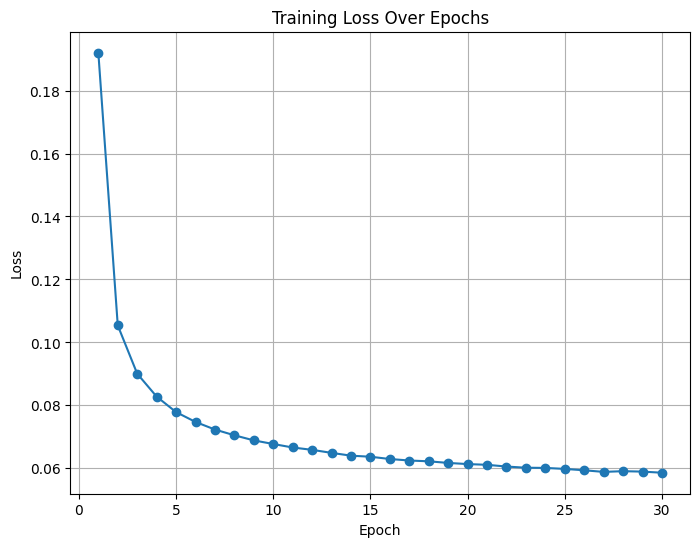

Train Accuracy: 0.9837, Train F1 Score: 0.9837
Test Accuracy: 0.9831, Test F1 Score: 0.9831


Training epochs: 100%|██████████| 30/30 [01:57<00:00,  3.92s/it]


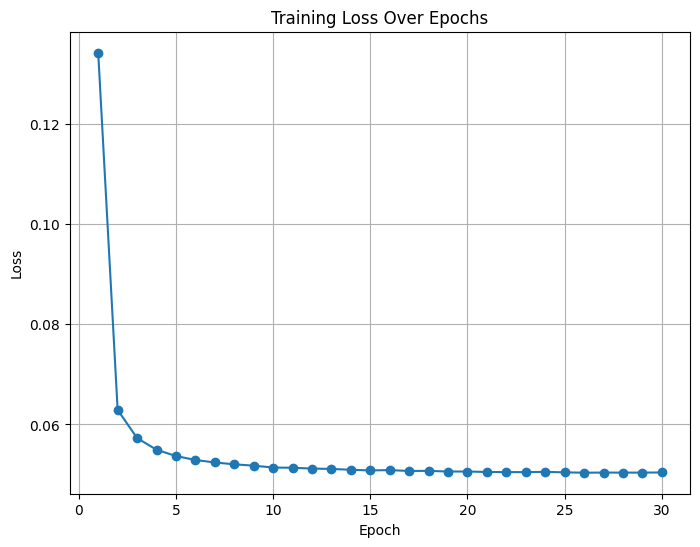

Train Accuracy: 0.9858, Train F1 Score: 0.9858
Test Accuracy: 0.9849, Test F1 Score: 0.9850


Training epochs: 100%|██████████| 30/30 [02:14<00:00,  4.47s/it]


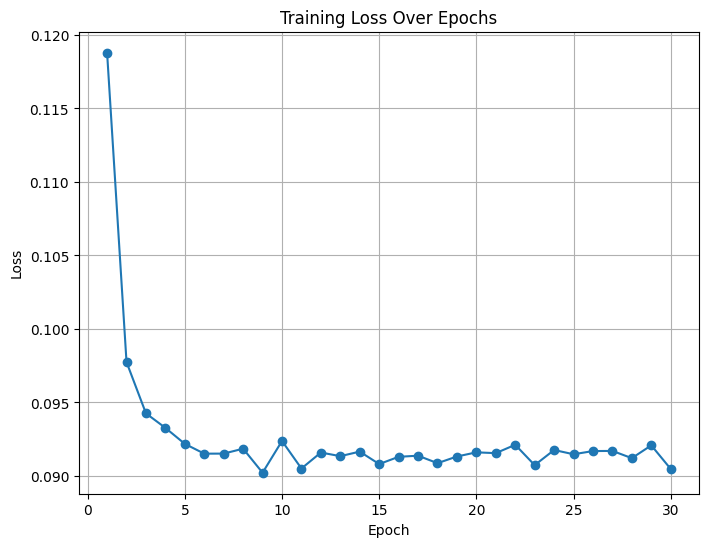

Train Accuracy: 0.9746, Train F1 Score: 0.9742
Test Accuracy: 0.9747, Test F1 Score: 0.9743


Training epochs: 100%|██████████| 30/30 [02:00<00:00,  4.03s/it]


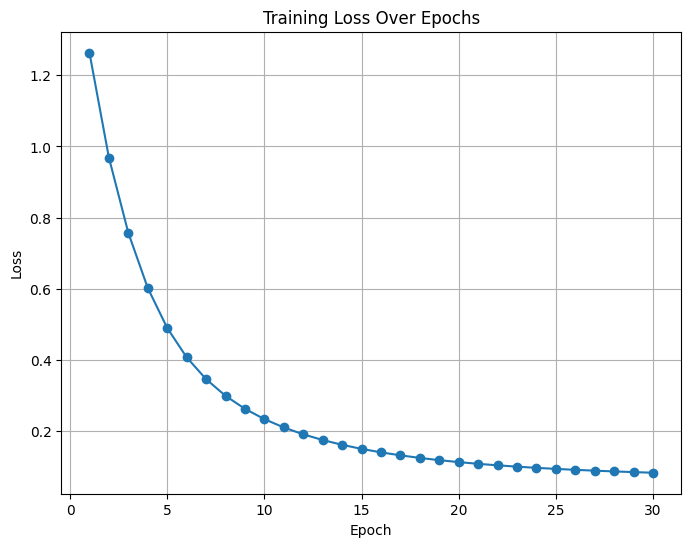

Train Accuracy: 0.9801, Train F1 Score: 0.9800
Test Accuracy: 0.9802, Test F1 Score: 0.9801
Decorrelation improvement: 0.0018787272665155008
BatchNorm improvement: -0.008782006370485984
Whitening improvement: -0.0030250874667910876


In [ ]:
# yatc - cicids17
f1_improvement("../data/yatc/cicids_emb.pkl", 8, mapping)

Training epochs: 100%|██████████| 30/30 [05:41<00:00, 11.39s/it]


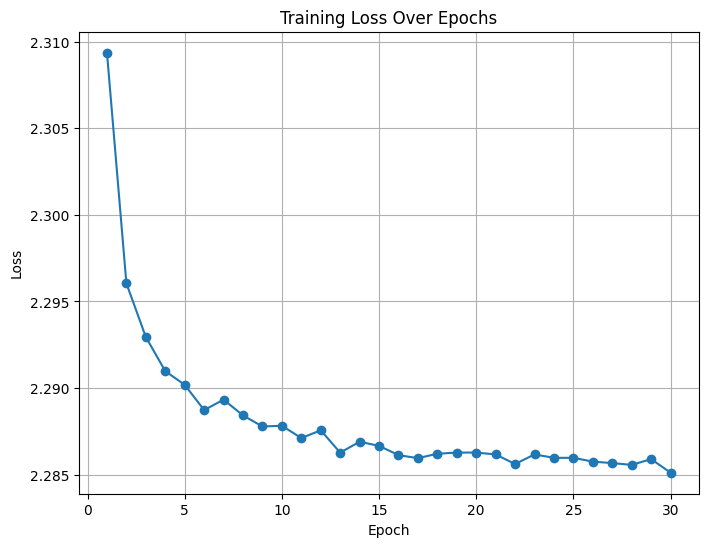

Train Accuracy: 0.1262, Train F1 Score: 0.0833
Test Accuracy: 0.1254, Test F1 Score: 0.0822


Training epochs: 100%|██████████| 30/30 [05:44<00:00, 11.48s/it]


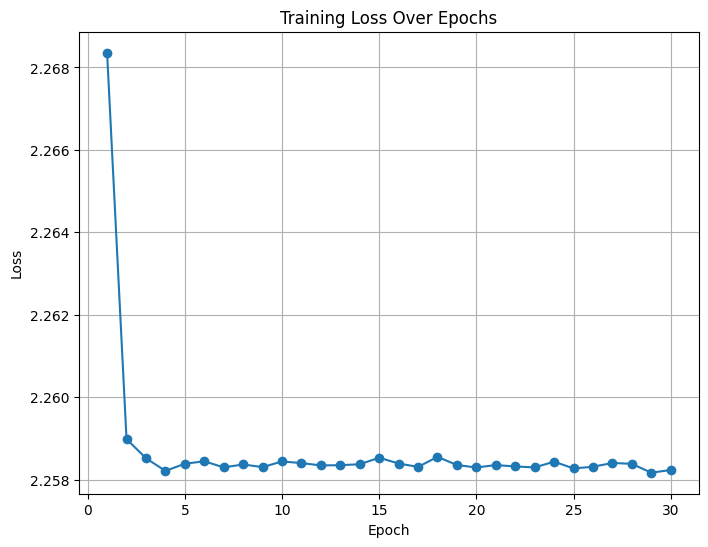

Train Accuracy: 0.1259, Train F1 Score: 0.0849
Test Accuracy: 0.1246, Test F1 Score: 0.0831


Training epochs: 100%|██████████| 30/30 [06:19<00:00, 12.63s/it]


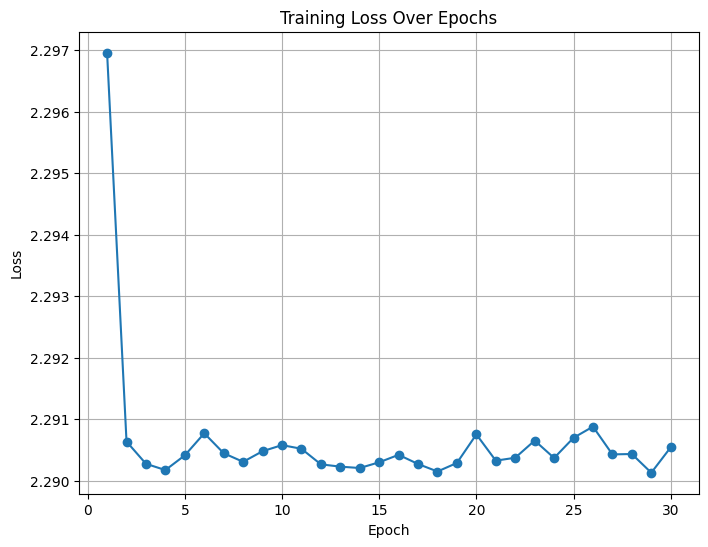

Train Accuracy: 0.1262, Train F1 Score: 0.0903
Test Accuracy: 0.1247, Test F1 Score: 0.0891


Training epochs: 100%|██████████| 30/30 [05:33<00:00, 11.12s/it]


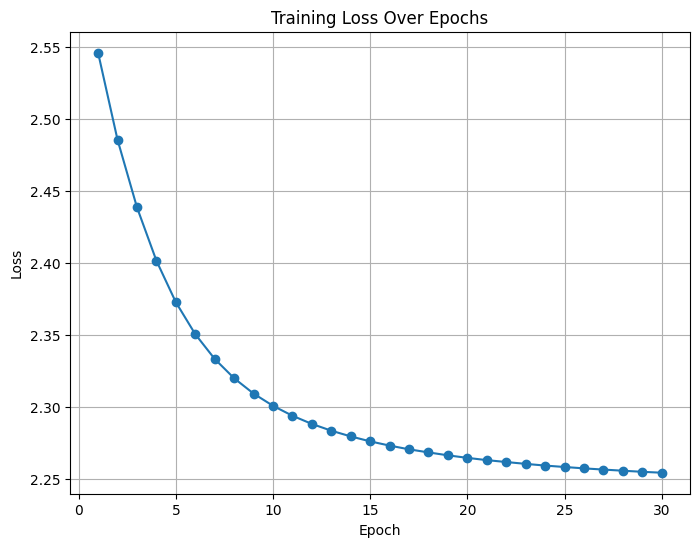

Train Accuracy: 0.1299, Train F1 Score: 0.0668
Test Accuracy: 0.1263, Test F1 Score: 0.0637
Decorrelation improvement: 0.0009228383182706135
BatchNorm improvement: 0.006889414149226697
Whitening improvement: -0.018467070969287624


In [ ]:
# yatc - cicapt
f1_improvement("../data/yatc/cicapt_emb.pkl", 22, mapping)

## etbert

In [ ]:
def mapping(x):
    return [i for i in x.removeprefix("/dev/shm/data/").removeprefix("/dev/shm/data2/").split('/') if i != ''][1]

Training epochs: 100%|██████████| 30/30 [00:06<00:00,  4.83it/s]


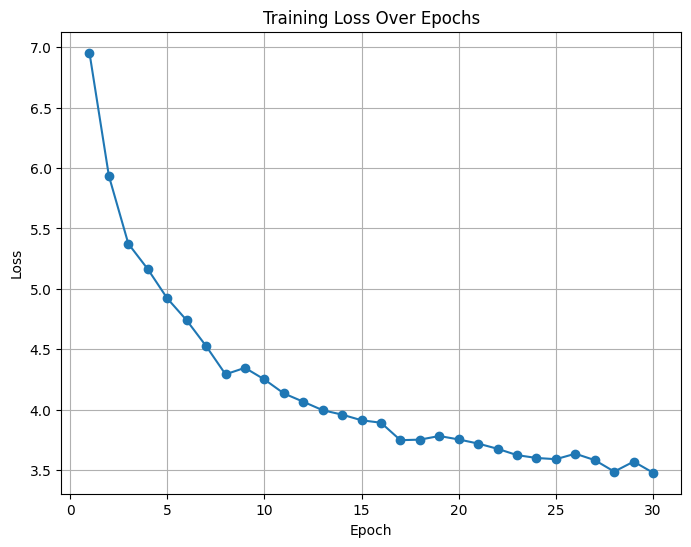

Train Accuracy: 0.2727, Train F1 Score: 0.2595
Test Accuracy: 0.0227, Test F1 Score: 0.0137


Training epochs: 100%|██████████| 30/30 [00:06<00:00,  4.64it/s]


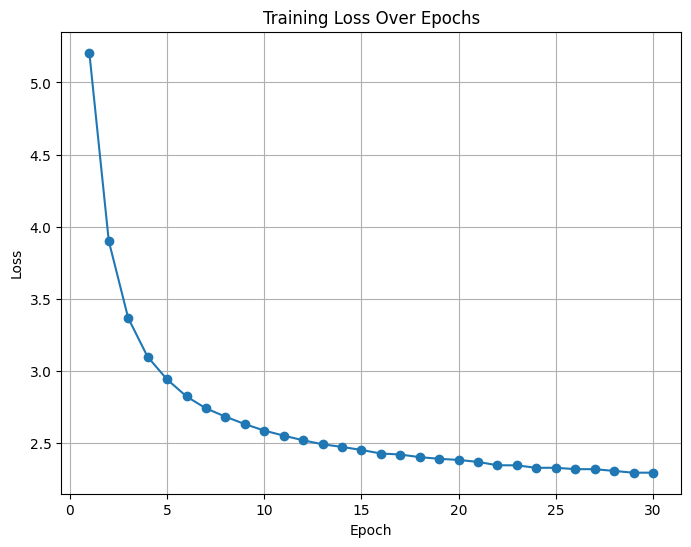

Train Accuracy: 0.5872, Train F1 Score: 0.5789
Test Accuracy: 0.0169, Test F1 Score: 0.0160


Training epochs: 100%|██████████| 30/30 [00:07<00:00,  4.21it/s]


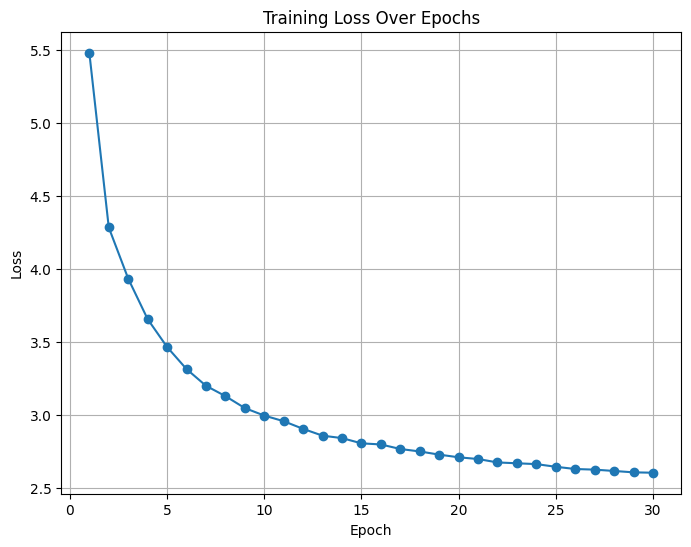

Train Accuracy: 0.4724, Train F1 Score: 0.4658
Test Accuracy: 0.0231, Test F1 Score: 0.0206


Training epochs: 100%|██████████| 30/30 [00:06<00:00,  4.75it/s]


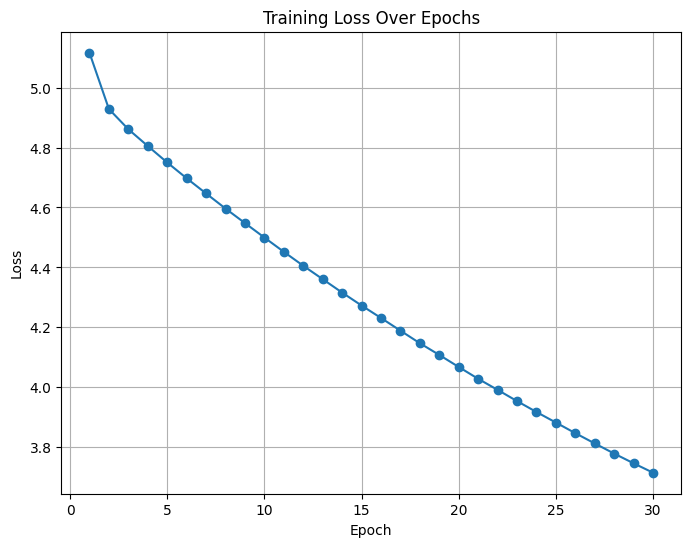

Train Accuracy: 0.2927, Train F1 Score: 0.3110
Test Accuracy: 0.0300, Test F1 Score: 0.0220
Decorrelation improvement: 0.0022720805162965256
BatchNorm improvement: 0.006934071373355433
Whitening improvement: 0.008312763038771508


In [ ]:
# etbert - Crossmarket
f1_improvement("../data/etbert/cross_emb.pkl", 210, mapping)

Training epochs: 100%|██████████| 30/30 [01:34<00:00,  3.14s/it]


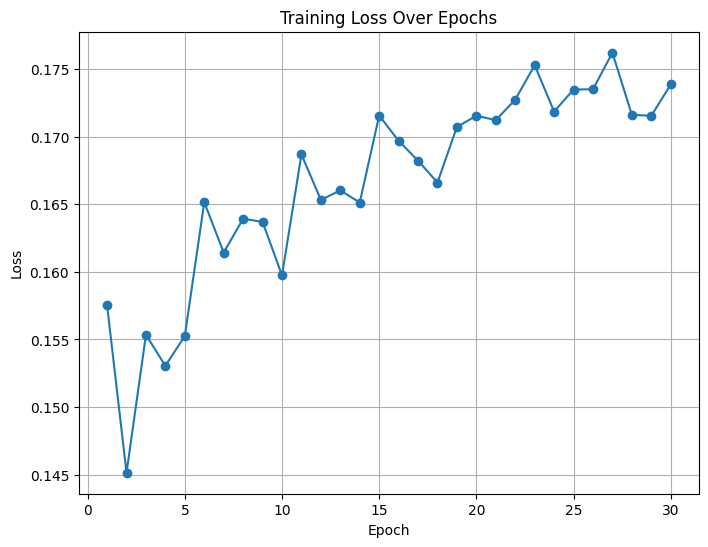

Train Accuracy: 0.9615, Train F1 Score: 0.9603
Test Accuracy: 0.9585, Test F1 Score: 0.9574


Training epochs: 100%|██████████| 30/30 [01:33<00:00,  3.12s/it]


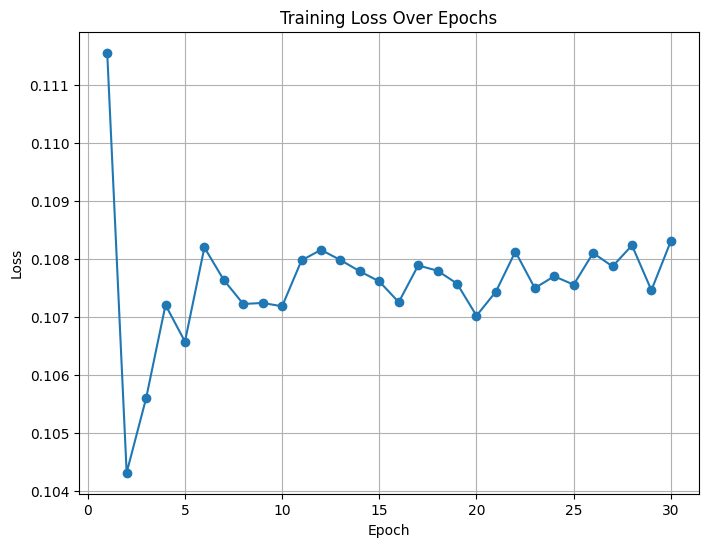

Train Accuracy: 0.9758, Train F1 Score: 0.9758
Test Accuracy: 0.9719, Test F1 Score: 0.9719


Training epochs: 100%|██████████| 30/30 [01:45<00:00,  3.52s/it]


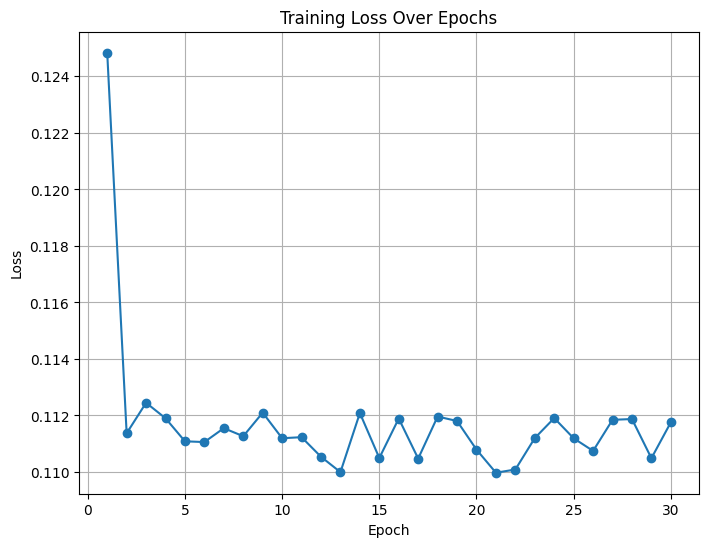

Train Accuracy: 0.9706, Train F1 Score: 0.9695
Test Accuracy: 0.9688, Test F1 Score: 0.9675


Training epochs: 100%|██████████| 30/30 [01:32<00:00,  3.07s/it]


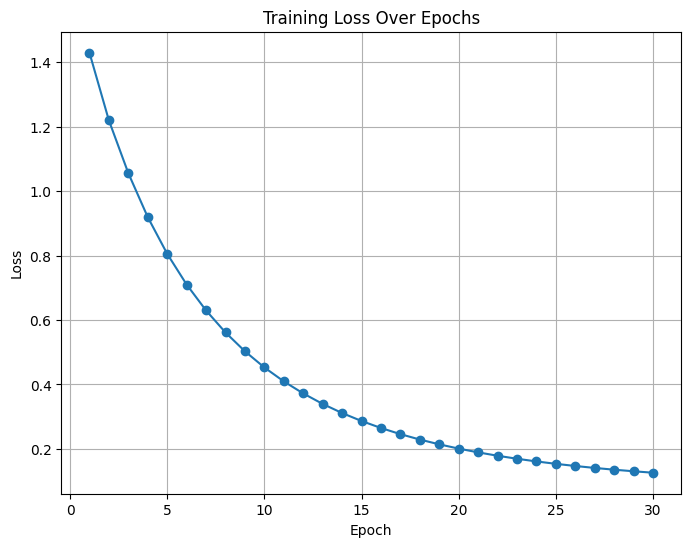

Train Accuracy: 0.9750, Train F1 Score: 0.9747
Test Accuracy: 0.9744, Test F1 Score: 0.9740
Decorrelation improvement: 0.014440491522491383
BatchNorm improvement: 0.010133516015716881
Whitening improvement: 0.016595485213016792


In [ ]:
# etbert - cicids17
f1_improvement("../data/etbert/cicids_emb.pkl", 8, mapping)

Training epochs: 100%|██████████| 30/30 [04:23<00:00,  8.77s/it]


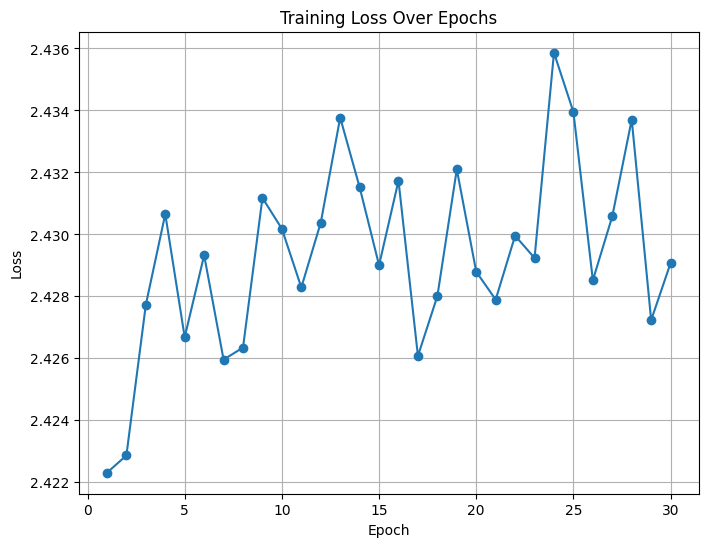

Train Accuracy: 0.1285, Train F1 Score: 0.0845
Test Accuracy: 0.1251, Test F1 Score: 0.0816


Training epochs: 100%|██████████| 30/30 [04:18<00:00,  8.62s/it]


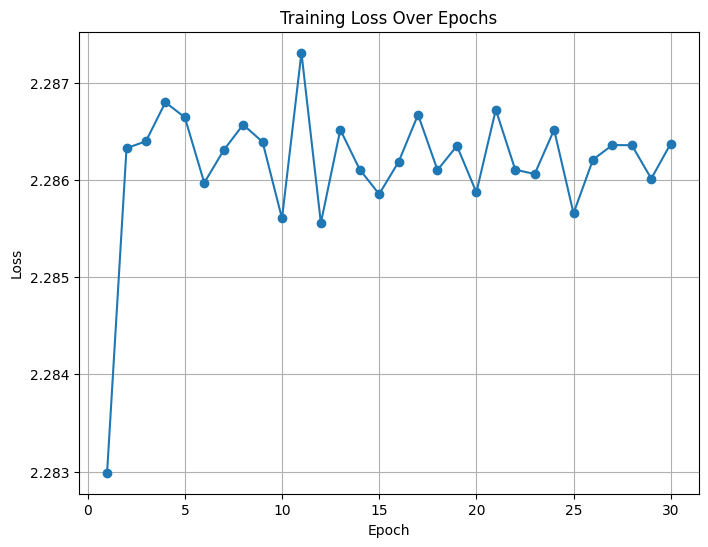

Train Accuracy: 0.1333, Train F1 Score: 0.1253
Test Accuracy: 0.1277, Test F1 Score: 0.1201


Training epochs: 100%|██████████| 30/30 [04:51<00:00,  9.73s/it]


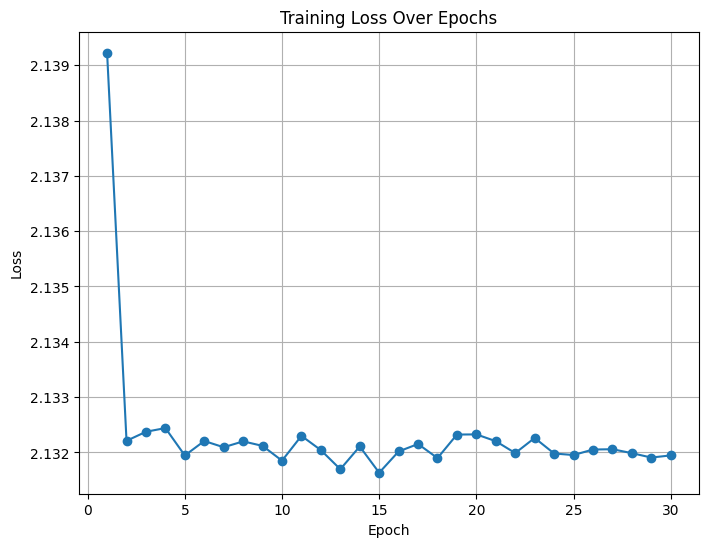

Train Accuracy: 0.1372, Train F1 Score: 0.0903
Test Accuracy: 0.1363, Test F1 Score: 0.0895


Training epochs: 100%|██████████| 30/30 [04:17<00:00,  8.59s/it]


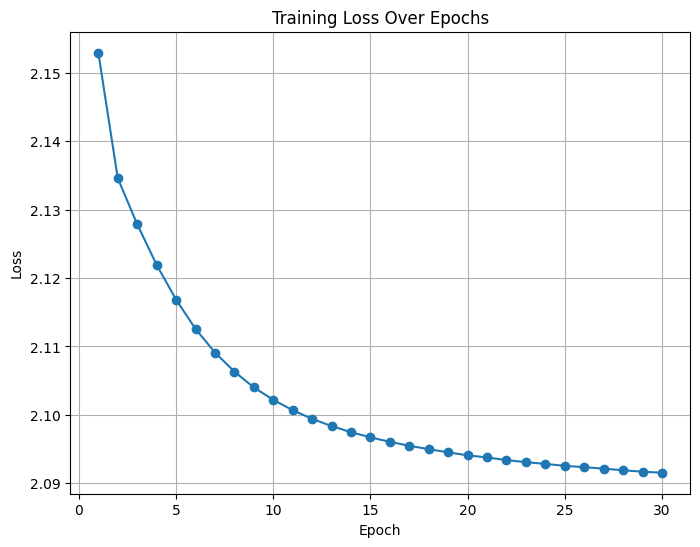

Train Accuracy: 0.1532, Train F1 Score: 0.1134
Test Accuracy: 0.1396, Test F1 Score: 0.1026
Decorrelation improvement: 0.038478124183564125
BatchNorm improvement: 0.007939330156834082
Whitening improvement: 0.021002714635442316


In [ ]:
# etbert - cicapt
f1_improvement("../data/etbert/cicapt_emb.pkl", 22, mapping)

## netfound

Training epochs: 100%|██████████| 30/30 [00:09<00:00,  3.09it/s]


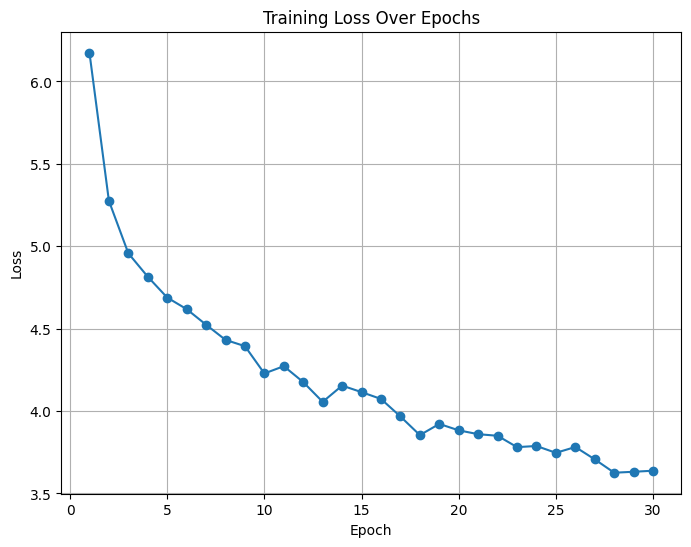

Train Accuracy: 0.3834, Train F1 Score: 0.4018
Test Accuracy: 0.2844, Test F1 Score: 0.2949


Training epochs: 100%|██████████| 30/30 [00:09<00:00,  3.04it/s]


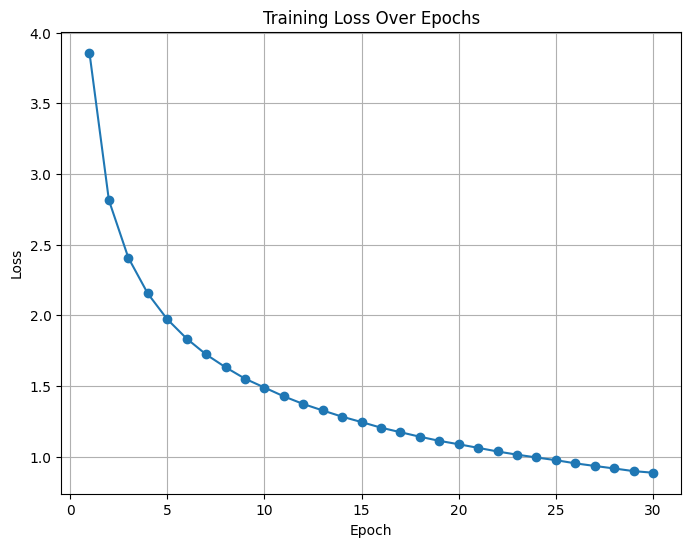

Train Accuracy: 0.8196, Train F1 Score: 0.8221
Test Accuracy: 0.3621, Test F1 Score: 0.3591


Training epochs: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s]


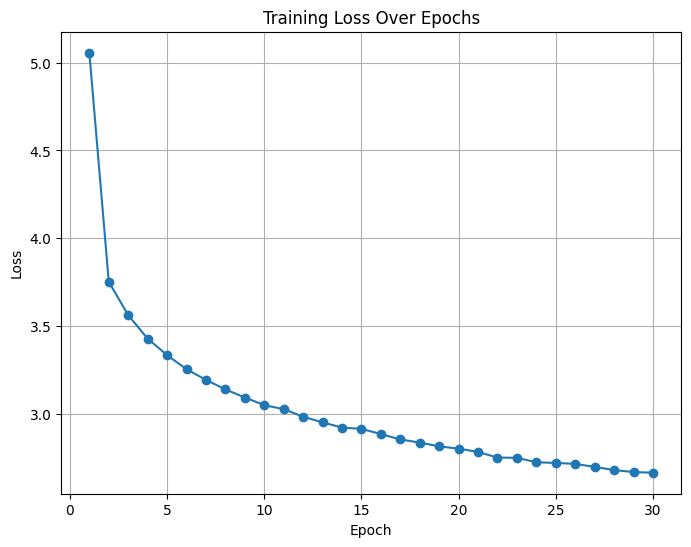

Train Accuracy: 0.4497, Train F1 Score: 0.4572
Test Accuracy: 0.3127, Test F1 Score: 0.3111


Training epochs: 100%|██████████| 30/30 [00:09<00:00,  3.04it/s]


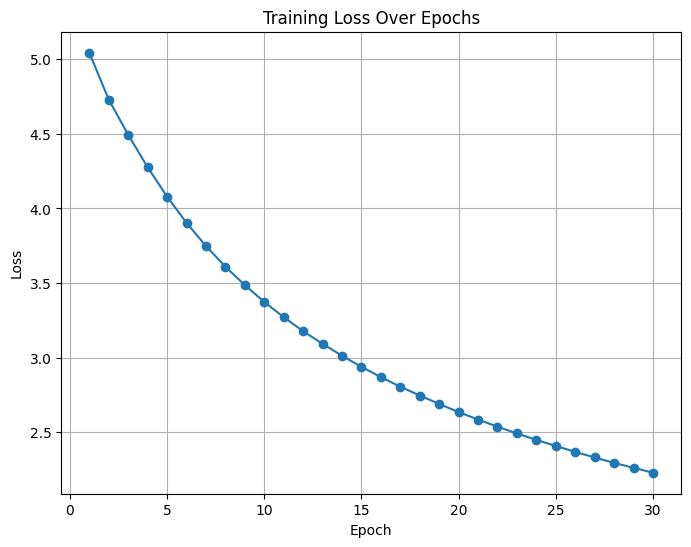

Train Accuracy: 0.5747, Train F1 Score: 0.5891
Test Accuracy: 0.3716, Test F1 Score: 0.3685
Decorrelation improvement: 0.06419866826861664
BatchNorm improvement: 0.016111964401411605
Whitening improvement: 0.07351612017619585


In [ ]:
# netfound - Crossmarket
def mapping(x):
    return x.removeprefix("/data/").split('-')[0]

f1_improvement("../data/netfound/cross_emb.pkl", 210, mapping)

Training epochs: 100%|██████████| 30/30 [01:56<00:00,  3.87s/it]


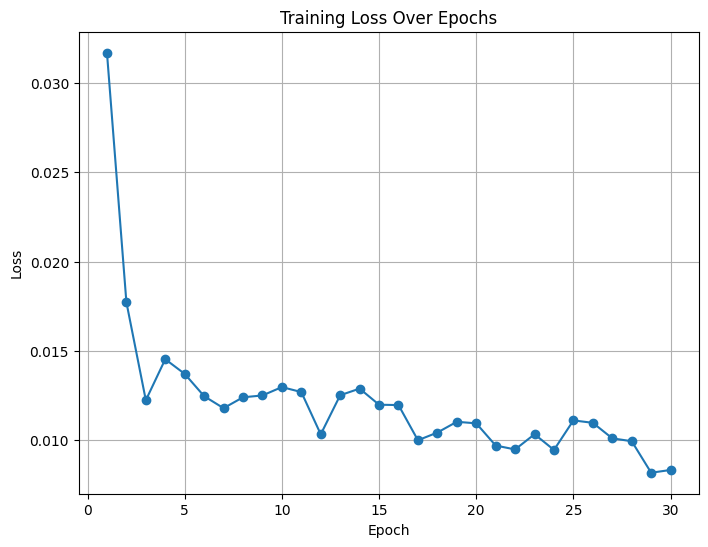

Train Accuracy: 0.9984, Train F1 Score: 0.9984
Test Accuracy: 0.9984, Test F1 Score: 0.9985


Training epochs: 100%|██████████| 30/30 [01:57<00:00,  3.92s/it]


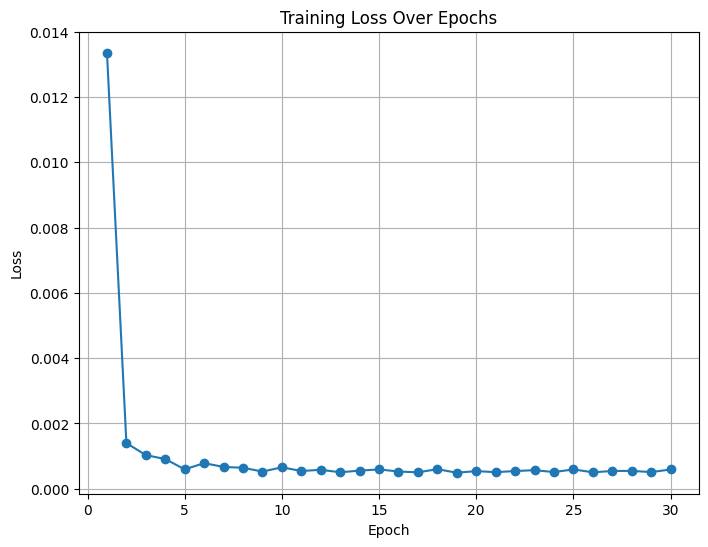

Train Accuracy: 0.9999, Train F1 Score: 0.9999
Test Accuracy: 0.9998, Test F1 Score: 0.9998


Training epochs: 100%|██████████| 30/30 [02:13<00:00,  4.46s/it]


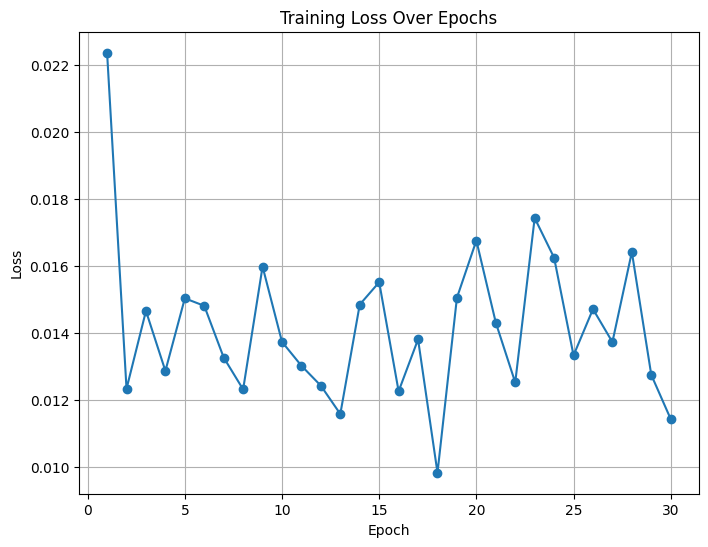

Train Accuracy: 0.9997, Train F1 Score: 0.9997
Test Accuracy: 0.9996, Test F1 Score: 0.9996


Training epochs: 100%|██████████| 30/30 [01:56<00:00,  3.87s/it]


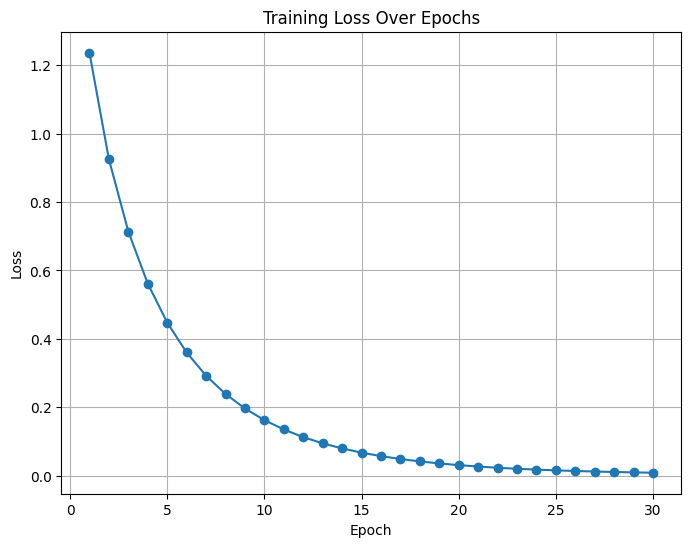

Train Accuracy: 0.9996, Train F1 Score: 0.9996
Test Accuracy: 0.9994, Test F1 Score: 0.9994
Decorrelation improvement: 0.0013344999411805114
BatchNorm improvement: 0.001137060227620279
Whitening improvement: 0.0009394159550013548


In [ ]:
# netfound - cicids17
def mapping(x):
    return '-'.join(x.removeprefix('/data/').split('_')[1:3]).split('.')[0]

f1_improvement("../data/netfound/cicids_emb.pkl", 8, mapping)

Training epochs: 100%|██████████| 30/30 [05:29<00:00, 11.00s/it]


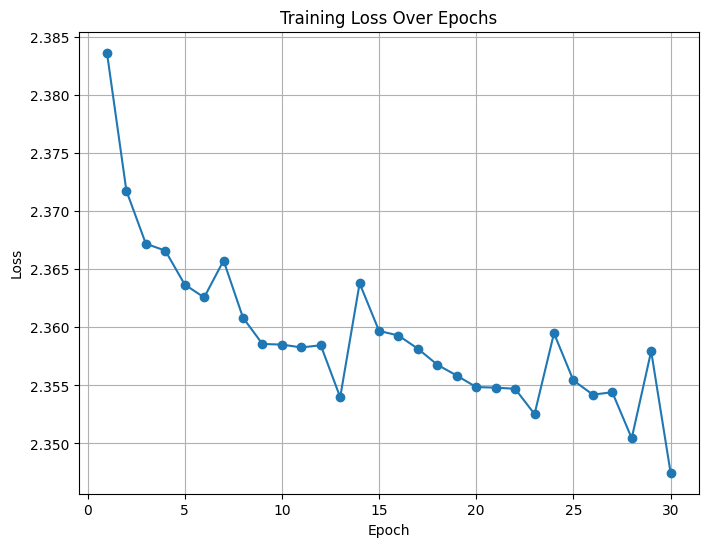

Train Accuracy: 0.1768, Train F1 Score: 0.1023
Test Accuracy: 0.1740, Test F1 Score: 0.0997


Training epochs: 100%|██████████| 30/30 [05:29<00:00, 11.00s/it]


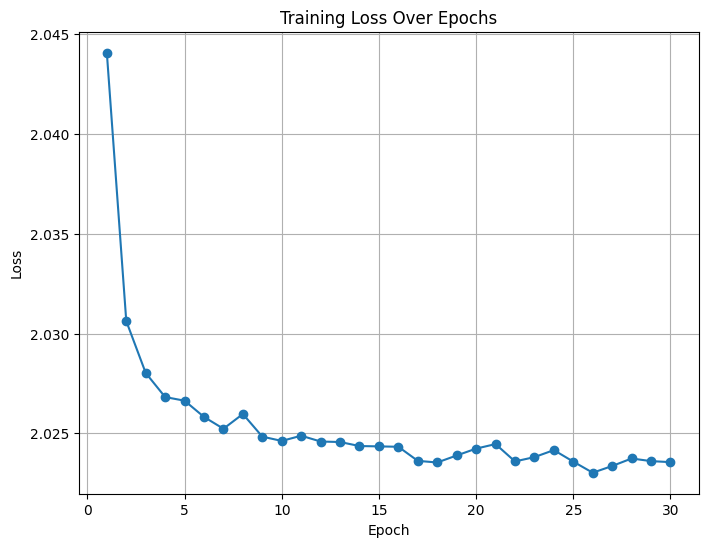

Train Accuracy: 0.2009, Train F1 Score: 0.1583
Test Accuracy: 0.1962, Test F1 Score: 0.1532


Training epochs: 100%|██████████| 30/30 [06:09<00:00, 12.33s/it]


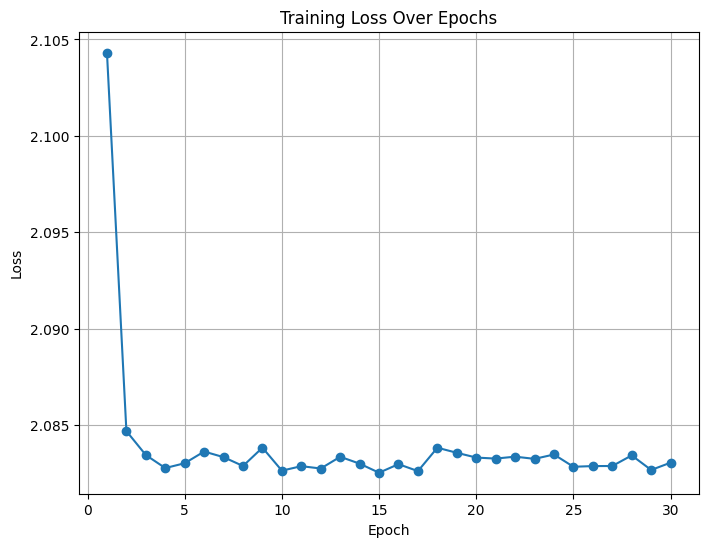

Train Accuracy: 0.1889, Train F1 Score: 0.1486
Test Accuracy: 0.1866, Test F1 Score: 0.1465


Training epochs: 100%|██████████| 30/30 [05:31<00:00, 11.07s/it]


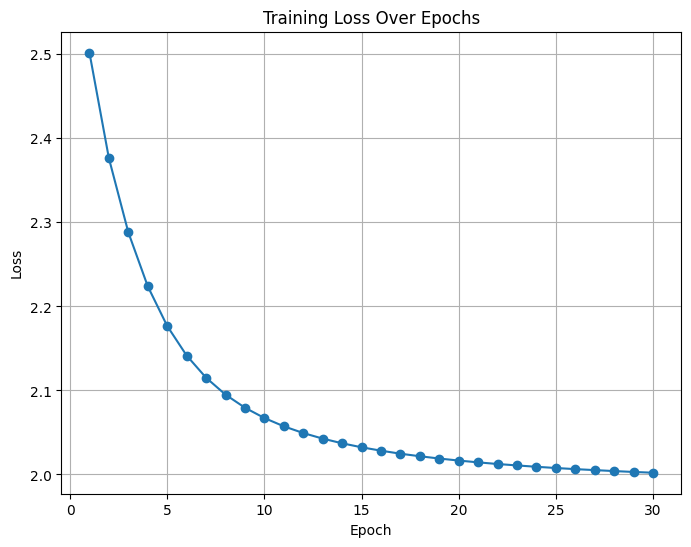

Train Accuracy: 0.2092, Train F1 Score: 0.1750
Test Accuracy: 0.1979, Test F1 Score: 0.1641
Decorrelation improvement: 0.053494208689028946
BatchNorm improvement: 0.046819100440642206
Whitening improvement: 0.0643878065703732


In [ ]:
# netfound - cicapt
def mapping(x):
    return '-'.join(x.removeprefix("/data/").split('-')[:3])

f1_improvement("../data/netfound/cicapt_emb.pkl", 22, mapping)

Training epochs: 100%|██████████| 60/60 [00:19<00:00,  3.06it/s]


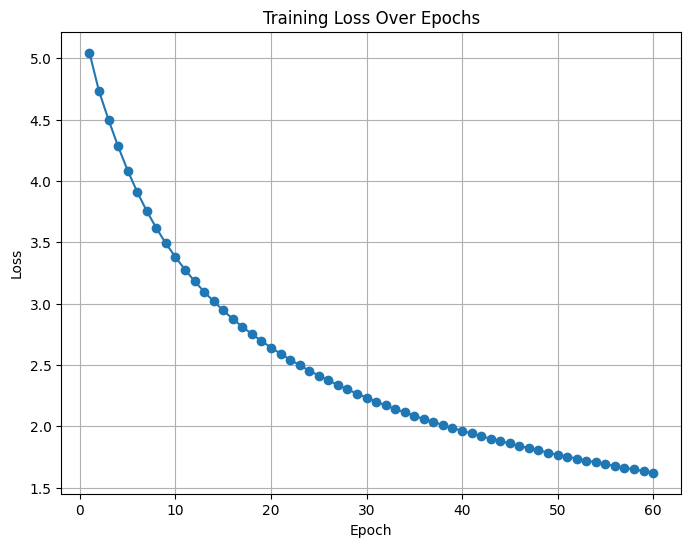

Train Accuracy: 0.6764, Train F1 Score: 0.6836
Test Accuracy: 0.3837, Test F1 Score: 0.3789
0.37888707380657055


In [ ]:
# custom calculations

# netfound - Crossmarket
def mapping(x):
    return x.removeprefix("/data/").split('-')[0]

with open("../data/netfound/cross_emb.pkl", "rb") as f:
    embeddings, filenames = pickle.load(f)

filenames = [mapping(x) for x in filenames]
f12 = train(whitening_torch_final(embeddings), filenames, 210, 60)
print(f12)